** Testing the model trained on predicting eye gaze coordinates on webcam images **

**Authors: Aditya Ashtekar, Nitin Patil**

This is part of a project for the course Deep Learning taken at New York University.

Installing requried dependencies

In [2]:
!pip install mtcnn
from mtcnn.mtcnn import MTCNN
import cv2
import matplotlib.pyplot as plt

     |████████████████████████████████| 2.3MB 5.0MB/s 


In [3]:
import math
import numpy as np
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary

We have saved the images taken from webcam in offScreeen and onScreen folders, depending on where the user was looking.

In [ ]:
!tar -xvf testImages.tar
!mv /testImages/ ./

In [13]:
faces = []
faces_file_paths = ["offScreen/", "onScreen/"]
for file_path in faces_file_paths:
  face_files = !ls $file_path
  faces += [file_path+img_name for face in face_files for img_name in face.split()]
print(faces)

['offScreen/Aditya1.jpg', 'offScreen/Aditya5.jpg', 'offScreen/Nitin3.jpg', 'offScreen/Nitin4.jpg', 'offScreen/Nitin6.jpg', 'onScreen/Aditya2.jpg', 'onScreen/Aditya3.jpg', 'onScreen/Aditya4.jpg', 'onScreen/Nitin1.jpg', 'onScreen/Nitin2.jpg']


We are using MTCNN library to detect eye features from a given image. The detector object is to get eye landmark features from a image containing a face.

In [14]:
detector = MTCNN()

Helper functions to get eye coordinates from the images

We are getting center of the eye point with MTCNN, from that we are extracting the eye image by taking 1/10th of the size of height and width of the whole image on both the sides.

In [15]:
# Helper function to crop and resize the eye image
def getEyeImage(eyeImg, kp, eye, width_th, height_th):
  eyeImg = eyeImg[kp[eye][1]-width_th:kp[eye][1]+width_th,kp[eye][0]-height_th:kp[eye][0]+height_th]
  eyeImg = cv2.resize(eyeImg, dsize=(60,36))
  return eyeImg


# Using detector.detect_faces get eye keypoints
# return left_eye and right_eye images of size 36 x 60 each
def extractEyes(image):
  landmarks = detector.detect_faces(image)[0]
  
  width_th = landmarks['box'][2]//10
  height_th = landmarks['box'][3]//10

  kp = landmarks['keypoints']

  left_eye = getEyeImage(image, kp, 'left_eye', width_th, height_th)
  right_eye = getEyeImage(image, kp, 'right_eye', width_th, height_th)

  return [left_eye, right_eye]

Converting image to grayscale from RGB

In [16]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

### Image extraction and transformation

In [17]:
# eyeImages is a list of dict like 'left':left_eye, 'right':right_eye
# left_eye and right_eye are of size 36 x 60

#----------------Main Code for extracting normalized eye images------------------
faceImages = []
eyeImages = {'left':[], 'right':[]}
for idx, face in enumerate(faces):
  image_path = face
  image = plt.imread(image_path)
  faceImages.append(image)
  left_eye, right_eye = extractEyes(image)
  eyeImages['left'].append(rgb2gray(left_eye)/255)
  eyeImages['right'].append(rgb2gray(right_eye)/255)

Plotting the eye images extracted from the webcam images.

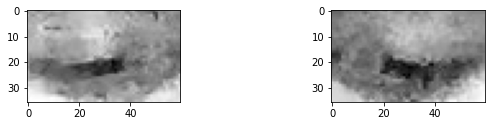

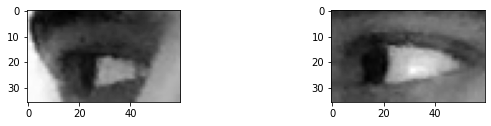

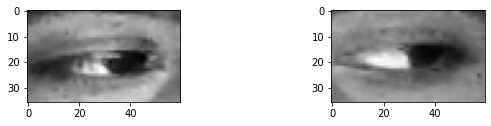

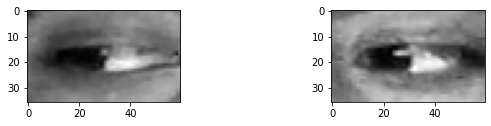

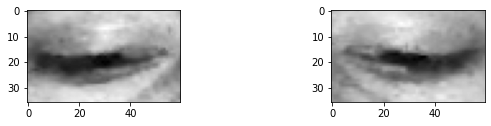

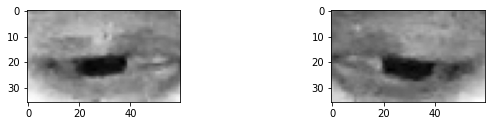

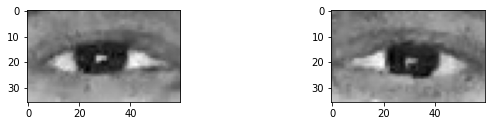

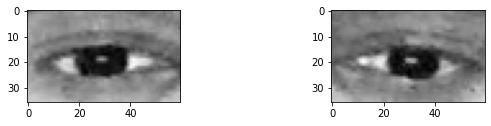

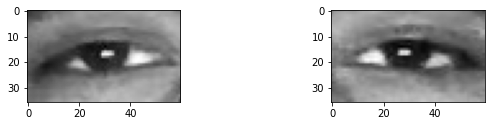

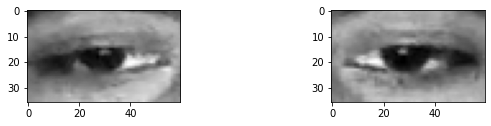

In [18]:
nrow = len(faces)
ncol = 2
numImages = 10
numTestImages = len(eyeImages['right'])
for idx in range(numTestImages):
  left_eye = eyeImages['left']
  right_eye = eyeImages['right']
  plt.figure(figsize=(10,20))
  fig = plt.subplot(nrow, ncol, idx*ncol+1)
  fig.imshow(left_eye[idx], cmap='gray')
  fig = plt.subplot(nrow, ncol, idx*ncol+2)
  fig.imshow(right_eye[idx], cmap='gray')
  plt.show()

As we can see, we are successfully able to extract the eye image and transform them to our requirement.

### Model description

Defining the same model again here, so we can load it.

In [19]:
class EyeGazeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(20, 50, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(50*6*12, 500)
        self.fc2 = nn.Linear(500, 3)

    def forward(self, x):
        y1 = self.pool1(F.relu(self.conv1(x)))
        y2 = self.pool2(F.relu(self.conv2(y1)))
        y3 = y2.view(-1, 50*6*12)
        y4 = self.fc1(y3)
        y5 = self.fc2(y4)
        return y5

#### Loading the trained model

In [21]:
model_path = "./fully_trained_model.pt"
model = torch.load(model_path)

Defining the loss for test images.

In [22]:
Loss = nn.MSELoss(size_average=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Helper functions.

In [23]:
def get2dGaze(x,y,z):
  theta = math.asin(-y)
  phi = math.atan2(-x, -z)
  return (theta, phi)

def RMS(x, y):
  return math.sqrt(x**2 + y**2)

Setting up thresholds for classifying the images to on screen and off screen. We are doing this because we did not have test labels available as on screen and off screen.

In [24]:
userMessage = ["Gaze on screen", "Gaze off screen"]
def checkThreshold(x,y,z,eye='right'):
    if (x >= -0.1 and x <= 0.15) and (y >= 0.04 and y <= 0.15):
      return 1
    return 0

In [25]:
outputGazeRight = []
outputGazeLeft = []
for idx, eyeImg in enumerate(eyeImages['right']):
  eyeImg = np.expand_dims(eyeImg, axis=0)
  eyeImg = np.expand_dims(eyeImg, axis=0)
  eyeRight = torch.from_numpy(eyeImg)
  
  yhat = model(eyeRight)
  outputGazeRight.append(yhat)

for idx, eyeImg in enumerate(eyeImages['left']):
  eyeImg = np.expand_dims(eyeImg, axis=0)
  eyeImg = np.expand_dims(eyeImg, axis=0)
  eyeLeft = torch.from_numpy(eyeImg)
  
  yhat = model(eyeLeft)
  outputGazeLeft.append(yhat)

3D Vector:		    -0.04  0.06  0.06	  -0.08  0.08  0.08
The user is looking On Screen


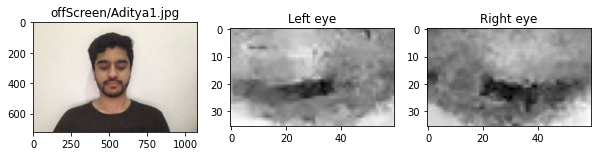

3D Vector:		    -0.08  0.10  0.10	  -0.15  0.07  0.07
The user is looking Off Screen


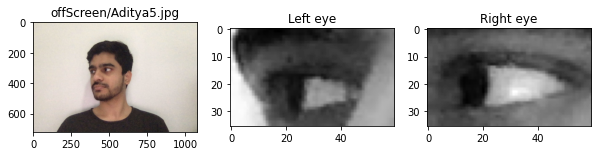

3D Vector:		    0.12  0.05  0.05	  0.20  0.08  0.08
The user is looking Off Screen


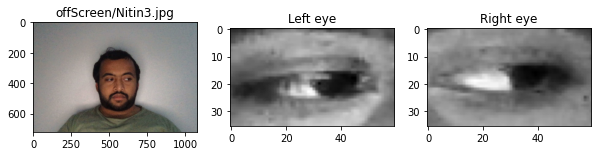

3D Vector:		    -0.24  0.10  0.10	  -0.32  0.08  0.08
The user is looking Off Screen


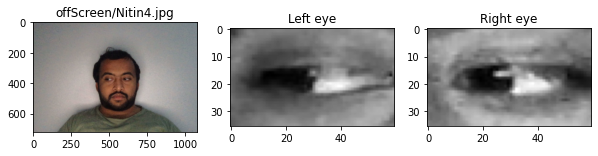

3D Vector:		    -0.02  0.15  0.15	  -0.02  0.18  0.18
The user is looking Off Screen


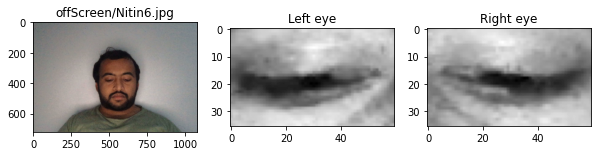

3D Vector:		    -0.07  0.12  0.12	  -0.06  0.08  0.08
The user is looking On Screen


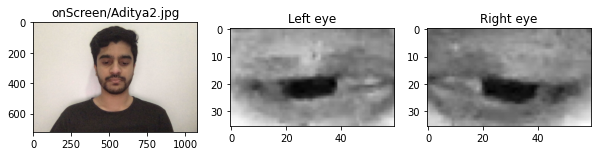

3D Vector:		    -0.01  0.04  0.04	  -0.07  0.10  0.10
The user is looking On Screen


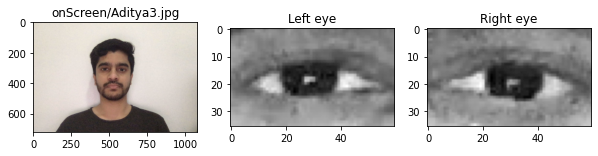

3D Vector:		    -0.05  0.09  0.09	  -0.03  0.13  0.13
The user is looking On Screen


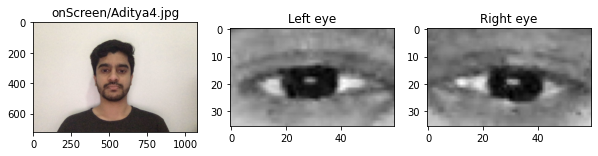

3D Vector:		    -0.02  0.06  0.06	  0.04  0.05  0.05
The user is looking On Screen


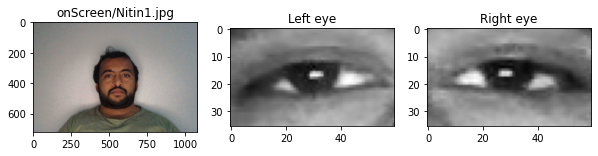

3D Vector:		    -0.01  0.10  0.10	  -0.01  0.11  0.11
The user is looking On Screen


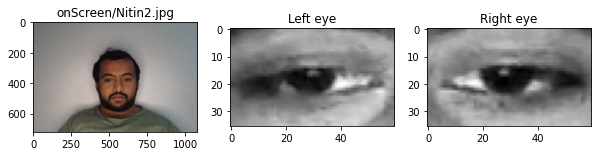

In [26]:
labels = ["Off Screen", "On Screen"]
for idx in range(len(faces)):
  xR, yR, zR = outputGazeRight[idx][0][0].item(), outputGazeRight[idx][0][1].item(), outputGazeRight[idx][0][1].item()
  xL, yL, zL = outputGazeLeft[idx][0][0].item(), outputGazeLeft[idx][0][1].item(), outputGazeLeft[idx][0][1].item()
  yhat = checkThreshold(xL,yL,zL,'left') and checkThreshold(xR,yR,zR,'right')

  print("3D Vector:\t\t    {:.2f}  {:.2f}  {:.2f}\t  {:.2f}  {:.2f}  {:.2f}".format(xL, yL, zL, xR, yR, zR))
  # print("2D Vector:\t\t    {:.2f}  {:.2f}\t\t  {:.2f}  {:.2f}".format(*get2dGaze(xL,yL,zL), *get2dGaze(xR,yR,zR)))

  print(f"The user is looking {labels[yhat]}")
  plt.figure(figsize=(10,3))
  plt.subplot(1,3,1)
  plt.imshow(faceImages[idx])
  plt.title(faces[idx])
  plt.subplot(1,3,2)
  plt.imshow(eyeImages['left'][idx], cmap = 'gray')
  plt.title("Left eye")
  plt.subplot(1,3,3)
  plt.imshow(eyeImages['right'][idx], cmap = 'gray')
  plt.title("Right eye")
  plt.show()

We are suceessfully able to classify (by regression) if the user is looking on screen or off screen.

The model is predicting good for all cases except for when the user is looking at the keyboard which is really a gray area whether to classify such images as on screen or off screen.